In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as np
from scipy.misc import imread, imresize
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from random import shuffle

%matplotlib inline

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
if False:
    INPUT_SIZE = (224, 224)
    ALL_DATA_DIR = '/home/datasets/places/all_scenes_224/'
else:
    INPUT_SIZE = (299, 299)
    ALL_DATA_DIR = '/home/datasets/places/all_scenes/'

TRAIN_DATA_DIR = ALL_DATA_DIR+'train'
VAL_DATA_DIR = ALL_DATA_DIR+'val'

---

# Places

In [5]:
PLACES_DIR = '/home/datasets/places/'
PLACES_CATEGORIES_FILE=PLACES_DIR+'categories_places365.txt'

In [114]:
def getCategories(filename):
    places_to_categories={}
    with open(filename,'r') as input_file:
        for ind,line in enumerate(input_file):
            row=line.rstrip().split(' ')
            places_to_categories[row[0]]=row[1]

    #print(places_to_categories['/r/river'])
    categories_to_places={places_to_categories[place]:place for place in places_to_categories}
    categories_to_dirs={places_to_categories[place]:place[3:].replace('/','_') for place in places_to_categories}
    return categories_to_dirs

In [115]:
categories_to_dirs=getCategories(PLACES_CATEGORIES_FILE)
#print(categories_to_dirs)

In [117]:
def save_links(filename, input_dir,dir_to_save,categories_to_dirs):
    with open(filename,'r') as input_file:
        for ind,line in enumerate(input_file):
            row=line.rstrip().split(' ')
            outdir_path=os.path.join(dir_to_save,categories_to_dirs[row[1]])
            if not os.path.exists(outdir_path):
                os.makedirs(outdir_path)
            src_file_path=input_dir+row[0]
            dst_file_path=os.path.join(outdir_path,os.path.basename(src_file_path))
            #print(src_file_path,dst_file_path)
            os.symlink(src_file_path,dst_file_path)

In [76]:
#Validation
PLACES_VAL_DATA_DIR = PLACES_DIR+'val_large/'
PLACES_VAL_DESCR_FILE=PLACES_DIR+'places365_val.txt'
save_links(PLACES_VAL_DESCR_FILE, PLACES_VAL_DATA_DIR,VAL_DATA_DIR,categories_to_dirs)

In [129]:
#Train
PLACES_TRAIN_DATA_DIR = PLACES_DIR+'data_large/'
PLACES_TRAIN_DESCR_FILE=PLACES_DIR+'places365_train_challenge.txt'
save_links(PLACES_TRAIN_DESCR_FILE, PLACES_TRAIN_DATA_DIR,TRAIN_DATA_DIR,categories_to_dirs)

# Places extra

In [58]:
EXTRA_CATEGORIES_FILE=PLACES_DIR+'categories_extra69.txt'
categories_to_dirs_extra=getCategories(EXTRA_CATEGORIES_FILE)
print(categories_to_dirs_extra)

{'43': 'hot_tub_indoor', '5': 'dining_car', '51': 'kennel_indoor', '15': 'warehouse_indoor', '50': 'funeral_home', '65': 'fitting_room_interior', '17': 'music_store', '40': 'anechoic_chamber', '55': 'forest_needleleaf', '47': 'rest_area', '3': 'lido_deck_outdoor', '22': 'tennis_court_indoor', '20': 'tennis_court_outdoor', '24': 'subway_interior', '28': 'basketball_court_outdoor', '16': 'volleyball_court_indoor', '61': 'brewery_indoor', '41': 'batters_box', '1': 'baggage_claim', '29': 'squash_court', '19': 'wine_cellar_barrel_storage', '13': 'ranch_house', '57': 'liquor_store_outdoor', '30': 'hat_shop', '46': 'dinette_vehicle', '59': 'poolroom_home', '60': 'driving_range_outdoor', '63': 'podium_indoor', '4': 'hot_tub_outdoor', '23': 'casino_indoor', '54': 'oil_refinery_outdoor', '0': 'toll_plaza', '8': 'courtroom', '45': 'observatory_outdoor', '62': 'outhouse_outdoor', '34': 'electrical_substation', '7': 'cheese_factory', '26': 'badminton_court_indoor', '6': 'videostore', '33': 'loft', 

In [74]:
#Validation
EXTRA_VAL_DATA_DIR = PLACES_DIR+'data_large_extra'
EXTRA_VAL_DESCR_FILE=PLACES_DIR+'imglist_test.txt'
save_links(EXTRA_VAL_DESCR_FILE, EXTRA_VAL_DATA_DIR,VAL_DATA_DIR,categories_to_dirs_extra)

In [130]:
#Train
EXTRA_TRAIN_DATA_DIR = PLACES_DIR+'data_large_extra'
EXTRA_TRAIN_DESCR_FILE=PLACES_DIR+'imglist_train.txt'
save_links(EXTRA_TRAIN_DESCR_FILE, EXTRA_TRAIN_DATA_DIR,TRAIN_DATA_DIR,categories_to_dirs_extra)

---

# Train

In [5]:
from keras.models import Model,load_model,model_from_json
from keras.applications import mobilenet,mobilenet_v2,densenet, xception, inception_resnet_v2,inception_v3,resnet, resnet_v2
from keras.utils.generic_utils import CustomObjectScope
from keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
#from keras.preprocessing.image import ImageDataGenerator
from myimage import ImageDataGenerator

#net_model=mobilenet_v2
#net_description='mobilenet2_alpha=1.0'
#net_model=densenet
#net_description='densenet121'
#net_model=mobilenet
#net_description='mobilenet_augm'
#net_model=inception_resnet_v2
#net_description='inception_resnet_v2'
#net_model=inception_v3
#net_description='inception_v3'
#net_model=resnet_v2
#net_description='resnet2_50'
net_model=resnet
net_description='resnet_101'

net_description='places_'+net_description

BATCH_SIZE=40 #512 #64 #32 #64

def save_model(model,filename):
    model.save_weights('weights.h5')
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('weights.h5')
    loaded_model.save(filename)

Using TensorFlow backend.


In [6]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [24]:
USE_EFFICENT_NET=True

if USE_EFFICENT_NET:
    import efficientnet.keras as enet

    base_model = enet.EfficientNetB3(weights='imagenet')
    #base_model.load_weights('/home/avsavchenko/distr/efficientnet/efficientnet-b3-weights.h5')

    INPUT_SIZE = base_model.input_shape[1]
    print(INPUT_SIZE)
    INPUT_SIZE=(INPUT_SIZE,INPUT_SIZE)
    target_size=INPUT_SIZE
    preprocessing_function=enet.preprocess_input
    net_description='enet3'
else:
    def random_crop(x, random_crop_size, sync_seed=None, **kwargs):
        np.random.seed(sync_seed)
        w, h = x.shape[1], x.shape[2]
        rangew = (w - random_crop_size[0]) // 2
        rangeh = (h - random_crop_size[1]) // 2
        offsetw = 0 if rangew == 0 else np.random.randint(rangew)
        offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
        return x[:, offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1]]

    preprocessing_function=net_model.preprocess_input
    target_size=INPUT_SIZE
    #preprocessing_function,target_size=my_preprocessing,(256,256)

380


In [46]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.

        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.

        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        #target_size=(img_height, img_width),
                                                        target_size=img_height,
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset,follow_links=True)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        #target_size=(img_height, img_width),
                                                        target_size=img_height,
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset,follow_links=True)

        # Number of images across all classes in image directory.
        self.samples = self.generator1.samples
        self.classes = self.generator1.classes

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.samples + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.

        Returns:
            int -- steps per epoch.
        """

        return self.samples // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.

        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.samples
        if self.samples > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        
        current_size=y1.shape[0] #self.batch_size
        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, current_size)

        X_l = l.reshape(current_size, 1, 1, 1)
        y_l = l.reshape(current_size, 1)

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [14]:
train_datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06,
                                   rotation_range=0.1, width_shift_range=-0.1, height_shift_range=-0.1, brightness_range=None, shear_range=0.0, 
                                   zoom_range=0.1, channel_shift_range=1.05, fill_mode='nearest', horizontal_flip=True, vertical_flip=False,
                                   preprocessing_function=preprocessing_function)
train_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

mc = ModelCheckpoint(net_description+'_augm.h5', monitor='val_acc', verbose=1, save_best_only=True)
tb = TensorBoard('logdir', write_graph=True, write_grads=True, write_images=True)


In [34]:
import gc
del val_generator
del train_generator
gc.collect()

420

In [35]:
BATCH_SIZE=8
val_generator = test_datagen.flow_from_directory(
    VAL_DATA_DIR, target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='categorical',follow_links=True)

if True:
    print(net_description,TRAIN_DATA_DIR)
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_DIR, target_size=target_size,
        batch_size=BATCH_SIZE, class_mode='categorical',follow_links=True)
else:
    train_generator = MixupImageDataGenerator(generator=train_datagen,
                                          directory=TRAIN_DATA_DIR,
                                          batch_size=BATCH_SIZE,
                                          img_height=INPUT_SIZE,
                                          img_width=INPUT_SIZE,
                                          alpha=0.2,
                                          subset='training')

Found 43100 images belonging to 431 classes.
enet4 /home/datasets/places/all_scenes/train
Found 8125174 images belonging to 431 classes.


In [26]:
N_CLASS=val_generator.num_classes
nb_train_samples=train_generator.samples
nb_validation_samples=val_generator.samples
print(N_CLASS,nb_train_samples,nb_validation_samples)

class_to_idx=val_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

#np.save('idx_to_class.npy',np.array(idx_to_class))

431 8125174 43100
{0: 'airfield', 1: 'airplane_cabin', 2: 'airport_terminal', 3: 'alcove', 4: 'alley', 5: 'amphitheater', 6: 'amusement_arcade', 7: 'amusement_park', 8: 'anechoic_chamber', 9: 'apartment_building_outdoor', 10: 'aquarium', 11: 'aqueduct', 12: 'arcade', 13: 'arch', 14: 'archaelogical_excavation', 15: 'archive', 16: 'arena_hockey', 17: 'arena_performance', 18: 'arena_rodeo', 19: 'army_base', 20: 'art_gallery', 21: 'art_school', 22: 'art_studio', 23: 'artists_loft', 24: 'assembly_line', 25: 'athletic_field_indoor', 26: 'athletic_field_outdoor', 27: 'atrium_public', 28: 'attic', 29: 'auditorium', 30: 'auto_factory', 31: 'auto_showroom', 32: 'badlands', 33: 'badminton_court_indoor', 34: 'baggage_claim', 35: 'bakery_shop', 36: 'balcony_exterior', 37: 'balcony_interior', 38: 'ball_pit', 39: 'ballroom', 40: 'bamboo_forest', 41: 'bank_vault', 42: 'banquet_hall', 43: 'bar', 44: 'barn', 45: 'barndoor', 46: 'baseball_field', 47: 'basement', 48: 'basketball_court_indoor', 49: 'basket

In [27]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [28]:
def net():
    if USE_EFFICENT_NET:
        global base_model
        x=base_model.layers[-2].output
    else:
        input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3)
        #base_model = mobilenet.MobileNet(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
        #base_model = mobilenetv2.MobileNetV2(alpha=1.0, input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
        #base_model = densenet.DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
        #base_model = inception_resnet_v2.InceptionResNetV2(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
        base_model = inception_v3.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
        #base_model = resnet_v2.ResNet50V2(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
        #base_model = resnet.ResNet101(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
    
        x=base_model.output
        
    #x = Dropout(0.5)(x)
    #N_CLASS=431
    x = Dense(N_CLASS, activation='softmax', use_bias=True)(x)
    model=Model(base_model.inputs, x)
    return model,base_model

In [36]:
model,base_model=net()

start_epoch=0

In [123]:
for l in base_model.layers:
    l.trainable=False
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy',top_k_categorical_accuracy])
model.summary()

mc = ModelCheckpoint(net_description+'_augm.h5', monitor='val_acc', verbose=1, save_best_only=True)

es=EarlyStopping(monitor='val_acc',patience=2)
FIRST_EPOCHS=1
hist1=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=FIRST_EPOCHS, verbose=1, 
                    initial_epoch=0, callbacks=[tb, mc, es], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

Epoch 1/1
 31471/203129 [===>..........................] - ETA: 71:36:14 - loss: 2.9920 - acc: 0.3197 - top_k_categorical_accuracy: 0.6120

KeyboardInterrupt: 

In [14]:
start_epoch=len(hist1.history['loss'])
model.load_weights(net_description+'_augm.h5')
for l in base_model.layers:
    l.trainable=True

In [37]:
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy',top_k_categorical_accuracy])
model.summary()
mc = ModelCheckpoint(net_description+'_augm_ft.h5', monitor='val_acc', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_acc',patience=2 )
SECOND_EPOCHS=4

hist2=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=SECOND_EPOCHS, verbose=1, 
                    initial_epoch=start_epoch, callbacks=[mc], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 380, 380, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 190, 190, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

__________________________________________________________________________________________________
block4d_se_expand (Conv2D)      (None, 1, 1, 672)    19488       block4d_se_reduce[0][0]          
__________________________________________________________________________________________________
block4d_se_excite (Multiply)    (None, 24, 24, 672)  0           block4d_activation[0][0]         
                                                                 block4d_se_expand[0][0]          
__________________________________________________________________________________________________
block4d_project_conv (Conv2D)   (None, 24, 24, 112)  75264       block4d_se_excite[0][0]          
__________________________________________________________________________________________________
block4d_project_bn (BatchNormal (None, 24, 24, 112)  448         block4d_project_conv[0][0]       
__________________________________________________________________________________________________
block4d_dr

Epoch 1/4
 455277/1015646 [============>.................] - ETA: 71:37:08 - loss: 3.0277 - acc: 0.2973 - top_k_categorical_accuracy: 0.5881

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 466299/1015646 [============>.................] - ETA: 70:11:49 - loss: 3.0128 - acc: 0.2998 - top_k_categorical_accuracy: 0.5913

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 476850/1015646 [=============>................] - ETA: 68:50:13 - loss: 2.9992 - acc: 0.3020 - top_k_categorical_accuracy: 0.5942

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 487700/1015646 [=============>................] - ETA: 67:28:23 - loss: 2.9854 - acc: 0.3041 - top_k_categorical_accuracy: 0.5971

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 497976/1015646 [=============>................] - ETA: 66:08:55 - loss: 2.9729 - acc: 0.3061 - top_k_categorical_accuracy: 0.5998

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 508932/1015646 [==============>...............] - ETA: 64:44:15 - loss: 2.9598 - acc: 0.3083 - top_k_categorical_accuracy: 0.6026

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 519170/1015646 [==============>...............] - ETA: 63:25:08 - loss: 2.9478 - acc: 0.3103 - top_k_categorical_accuracy: 0.6051

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 529940/1015646 [==============>...............] - ETA: 62:01:59 - loss: 2.9357 - acc: 0.3123 - top_k_categorical_accuracy: 0.6077

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 879243/1015646 [========================>.....] - ETA: 17:23:04 - loss: 2.6559 - acc: 0.3599 - top_k_categorical_accuracy: 0.6662

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1015646/1015646 [==============================] - 466590s 459ms/step - loss: 2.5849 - acc: 0.3723 - top_k_categorical_accuracy: 0.6809 - val_loss: 2.9374 - val_acc: 0.4233 - val_top_k_categorical_accuracy: 0.7207

Epoch 00001: val_acc improved from -inf to 0.42331, saving model to enet4_augm_ft.h5
Epoch 2/4
1015646/1015646 [==============================] - 462000s 455ms/step - loss: 1.9903 - acc: 0.4806 - top_k_categorical_accuracy: 0.8008 - val_loss: 2.7198 - val_acc: 0.4606 - val_top_k_categorical_accuracy: 0.7557

Epoch 00002: val_acc improved from 0.42331 to 0.46062, saving model to enet4_augm_ft.h5
Epoch 3/4
   6226/1015646 [..............................] - ETA: 126:59:24 - loss: 1.8842 - acc: 0.5024 - top_k_categorical_accuracy: 0.8182

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1015646/1015646 [==============================] - 462793s 456ms/step - loss: 1.8619 - acc: 0.5075 - top_k_categorical_accuracy: 0.8239 - val_loss: 2.6357 - val_acc: 0.4761 - val_top_k_categorical_accuracy: 0.7682

Epoch 00003: val_acc improved from 0.46062 to 0.47614, saving model to enet4_augm_ft.h5
Epoch 4/4
1015646/1015646 [==============================] - 486071s 479ms/step - loss: 1.7925 - acc: 0.5224 - top_k_categorical_accuracy: 0.8360 - val_loss: 2.5585 - val_acc: 0.4875 - val_top_k_categorical_accuracy: 0.7768

Epoch 00004: val_acc improved from 0.47614 to 0.48754, saving model to enet4_augm_ft.h5


In [38]:
model.load_weights(net_description+'_augm_ft.h5')
model.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy',top_k_categorical_accuracy])
model.summary()
mc = ModelCheckpoint(net_description+'_augm_ft_sgd.h5', monitor='val_acc', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_acc',patience=2)
second_epoch=start_epoch+len(hist2.history['loss'])
THIRD_EPOCHS=second_epoch+1 #2 #3

#import gc
#gc.collect()
hist3=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=THIRD_EPOCHS, verbose=1, 
                    initial_epoch=second_epoch, callbacks=[mc], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 380, 380, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 190, 190, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

Epoch 5/5
  53769/1015646 [>.............................] - ETA: 122:17:20 - loss: 1.7214 - acc: 0.5389 - top_k_categorical_accuracy: 0.8471

KeyboardInterrupt: 

In [20]:
#model.load_weights(net_description+'_augm_ft_sgd.h5')
print(model.evaluate_generator(val_generator, nb_validation_samples // BATCH_SIZE))

[2.0810632379445453, 0.531934645376903, 0.8260536576308949]


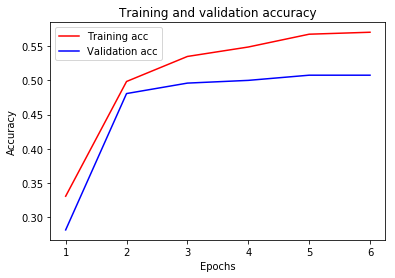

In [32]:
acc1 = hist1.history['acc']
val_acc1 = hist1.history['val_acc']

acc2 = hist2.history['acc']
val_acc2 = hist2.history['val_acc']

acc3 = hist3.history['acc']
val_acc3 = hist3.history['val_acc']

acc=np.concatenate((acc1,acc2,acc3),axis=0)
val_acc=np.concatenate((val_acc1,val_acc2,val_acc3),axis=0)
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

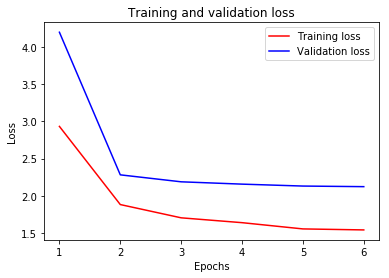

In [33]:
loss1 = hist1.history['loss']
val_loss1 = hist1.history['val_loss']

loss2 = hist2.history['loss']
val_loss2 = hist2.history['val_loss']

loss3 = hist3.history['loss']
val_loss3 = hist3.history['val_loss']

loss=np.concatenate((loss1,loss2,loss3),axis=0)
val_loss=np.concatenate((val_loss1,val_loss2,val_loss3),axis=0)
epochs = range(1, len(loss) + 1)

plt.clf()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validation

In [8]:
img_dirs = sorted(os.listdir(VAL_DATA_DIR))

In [9]:
net_file=net_description+'_augm_ft_sgd.h5'
if False:
    new_model=model
    new_model.load_weights(net_file)
else:
    new_model = load_model(net_file)
print(net_file)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


enet3_augm_ft_sgd.h5


In [21]:
save_model(model,net_description + '_model_augm_ft_sgd.h5')
new_model = load_model(net_description + '_model_augm_ft_sgd.h5')
new_model.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy',top_k_categorical_accuracy])

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [19]:
all_pred_classes={}
all_pred_scores={}
avg_topK_accuracy=0
val_ind=0
for label in img_dirs:
    img_dir=os.path.join(VAL_DATA_DIR,label)
    img_files = sorted(os.listdir(img_dir))
    pred_classes=[]
    pred_scores=[]
    num_correct_topK=0
    for f in img_files:
        val_ind+=1
        if False:
            img=val_images[val_ind]
        else:
            img=cv2.imread(os.path.join(img_dir,f))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,INPUT_SIZE)
            img=preprocessing_function(img.astype(np.float32))
        inp=np.expand_dims(img, axis=0)
        preds=new_model.predict(inp)[0]
        indices=preds.argsort()[::-1]
        predictions=[idx_to_class[ind] for ind in indices]
        if label in predictions[:5]:
            num_correct_topK+=1
        pred_classes.append(predictions)
        pred_scores.append(preds)
    topK_accuracy=num_correct_topK/len(img_files)
    avg_topK_accuracy+=topK_accuracy
    print(label,len(img_files),topK_accuracy)
    all_pred_classes[label]=pred_classes
    all_pred_scores[label]=pred_scores

avg_topK_accuracy/=len(img_dirs)
print('avg topK accuracy:',avg_topK_accuracy)

airfield 100 0.97
airplane_cabin 100 0.96
airport_terminal 100 0.91
alcove 100 0.86
alley 100 0.94
amphitheater 100 0.84
amusement_arcade 100 0.88
amusement_park 100 0.89
anechoic_chamber 100 0.87
apartment_building_outdoor 100 0.77
aquarium 100 0.94
aqueduct 100 0.84
arcade 100 0.9
arch 100 0.87
archaelogical_excavation 100 0.96
archive 100 0.78
arena_hockey 100 0.98
arena_performance 100 0.94
arena_rodeo 100 0.99
army_base 100 0.95
art_gallery 100 0.9
art_school 100 0.86
art_studio 100 0.81
artists_loft 100 0.79
assembly_line 100 0.63
athletic_field_indoor 100 0.6
athletic_field_outdoor 100 0.96
atrium_public 100 0.91
attic 100 0.96
auditorium 100 0.92
auto_factory 100 0.87
auto_showroom 100 0.97
badlands 100 0.81
badminton_court_indoor 100 0.89
baggage_claim 100 0.92
bakery_shop 100 0.86
balcony_exterior 100 0.78
balcony_interior 100 0.88
ball_pit 100 0.96
ballroom 100 0.89
bamboo_forest 100 0.99
bank_vault 100 0.74
banquet_hall 100 0.95
bar 100 0.77
barn 100 0.87
barndoor 100 0.9
b

teashop 100 0.51
television_room 100 0.94
television_studio 100 0.81
temple_asia 100 0.92
tennis_court_indoor 100 0.93
tennis_court_outdoor 100 0.95
theater_indoor_seats 100 0.0
thriftshop 100 0.22
throne_room 100 0.83
ticket_booth 100 0.7
toll_plaza 100 0.83
topiary_garden 100 0.81
tower 100 0.87
toyshop 100 0.8
train_interior 100 0.96
train_station_platform 100 0.97
tree_farm 100 0.74
tree_house 100 0.82
trench 100 0.91
tundra 100 0.87
underwater_ocean_deep 100 0.98
utility_room 100 0.86
valley 100 0.75
vegetable_garden 100 0.87
veterinarians_office 100 0.9
viaduct 100 0.87
videostore 100 0.84
village 100 0.85
vineyard 100 0.9
volcano 100 0.93
volleyball_court_indoor 100 0.94
volleyball_court_outdoor 100 0.93
waiting_room 100 0.87
walk_in_freezer 100 0.13
warehouse_indoor 100 0.72
water_park 100 0.92
water_tower 100 0.89
waterfall 100 0.98
watering_hole 100 0.83
wave 100 0.93
wet_bar 100 0.89
wheat_field 100 0.94
wind_farm 100 1.0
windmill 100 0.99
wine_cellar_barrel_storage 100 0.88

In [25]:
avg_topK_accuracy=0
class_accuracies={}
incorrect_labels={}
num_all_images=0

K=1
for label in img_dirs:
    num_correct_topK=0
    for predictions in all_pred_classes[label]:
        num_all_images+=1
        if label in predictions[:K]:
            num_correct_topK+=1
        else:
            for l in predictions[:K]:
                if l in incorrect_labels:
                    incorrect_labels[l]+=1
                else:
                    incorrect_labels[l]=1
    topK_accuracy=num_correct_topK/len(all_pred_classes[label])
    class_accuracies[label]=topK_accuracy
    avg_topK_accuracy+=topK_accuracy
    print(label,topK_accuracy)

avg_topK_accuracy/=len(img_dirs)
print('avg topK accuracy:',avg_topK_accuracy)

airfield 0.7
airplane_cabin 0.82
airport_terminal 0.68
alcove 0.33
alley 0.73
amphitheater 0.58
amusement_arcade 0.74
amusement_park 0.69
anechoic_chamber 0.71
apartment_building_outdoor 0.36
aquarium 0.89
aqueduct 0.54
arcade 0.46
arch 0.24
archaelogical_excavation 0.6
archive 0.42
arena_hockey 0.98
arena_performance 0.61
arena_rodeo 0.88
army_base 0.86
art_gallery 0.64
art_school 0.44
art_studio 0.36
artists_loft 0.2
assembly_line 0.15
athletic_field_indoor 0.14
athletic_field_outdoor 0.58
atrium_public 0.53
attic 0.82
auditorium 0.62
auto_factory 0.38
auto_showroom 0.91
badlands 0.73
badminton_court_indoor 0.31
baggage_claim 0.78
bakery_shop 0.57
balcony_exterior 0.54
balcony_interior 0.59
ball_pit 0.84
ballroom 0.75
bamboo_forest 0.89
bank_vault 0.49
banquet_hall 0.78
bar 0.41
barn 0.62
barndoor 0.47
baseball_field 0.78
basement 0.36
basketball_court_indoor 0.89
basketball_court_outdoor 0.56
bathroom 0.84
batters_box 0.0
bazaar_indoor 0.23
bazaar_outdoor 0.53
beach 0.53
beach_house

# Pruning

In [24]:
import sys
new_sys_dir = os.path.join('..','keras-surgeon','src')
if not new_sys_dir in sys.path:
    sys.path.append(new_sys_dir)

#import importlib
#import kerassurgeon
#importlib.reload(kerassurgeon)
#from kerassurgeon import identify,utils
from kerassurgeon.operations import delete_channels
#from kerassurgeon import Surgeon

import keras.backend as K

In [97]:
#K.clear_session()
#tf.reset_default_graph()
reduced_model, bm=net()
reduced_model.load_weights(net_description+'_augm_ft_sgd.h5')
layers=[]
for l in bm.layers:
    if type(l) is Conv2D:# or type(l) is DepthwiseConv2D:
        print(l.name,l)
        layers.append(l.name)
print(layers)

Conv1 <keras.layers.convolutional.Conv2D object at 0x7f12bed83780>
expanded_conv_project <keras.layers.convolutional.Conv2D object at 0x7f12bfa9ad68>
block_1_expand <keras.layers.convolutional.Conv2D object at 0x7f12c6fb2278>
block_1_project <keras.layers.convolutional.Conv2D object at 0x7f12c6d0c630>
block_2_expand <keras.layers.convolutional.Conv2D object at 0x7f12c6cb59e8>
block_2_project <keras.layers.convolutional.Conv2D object at 0x7f12c6aa87b8>
block_3_expand <keras.layers.convolutional.Conv2D object at 0x7f12c6996b00>
block_3_project <keras.layers.convolutional.Conv2D object at 0x7f12bfcdfc88>
block_4_expand <keras.layers.convolutional.Conv2D object at 0x7f12bfc24550>
block_4_project <keras.layers.convolutional.Conv2D object at 0x7f12bf9d1cf8>
block_5_expand <keras.layers.convolutional.Conv2D object at 0x7f12bf8c7748>
block_5_project <keras.layers.convolutional.Conv2D object at 0x7f12bf76bda0>
block_6_expand <keras.layers.convolutional.Conv2D object at 0x7f12bec84400>
block_6_p

In [98]:
import numpy as np
from keras.layers import Layer
from keras.activations import linear


def clean_copy(model):
    """Returns a copy of the model without other model uses of its layers."""
    weights = model.get_weights()
    new_model = model.__class__.from_config(model.get_config())
    new_model.set_weights(weights)
    return new_model


def get_channels_attr(layer):
    layer_config = layer.get_config()
    if 'units' in layer_config.keys():
        channels_attr = 'units'
    elif 'filters' in layer_config.keys():
        channels_attr = 'filters'
    else:
        raise ValueError('This layer has not got any channels.')
    return channels_attr


def get_node_depth(model, node):
    """Get the depth of a node in a model.
    Arguments:
        model: Keras Model object
        node: Keras Node object
    Returns:
        The node depth as an integer. The model outputs are at depth 0.
    Raises:
        KeyError: if the node is not contained in the model.
    """
    for (depth, nodes_at_depth) in get_nodes_by_depth(model).items():
        if node in nodes_at_depth:
            return depth
    raise KeyError('The node is not contained in the model.')


def check_for_layer_reuse(model, layers=None):
    """Returns True if any layers are reused, False if not."""
    if layers is None:
        layers = model.layers
    return any([len(get_inbound_nodes(l)) > 1 for l in layers])


def find_nodes_in_model(model, layer):
    """Find the indices of layer's inbound nodes which are in model"""
    model_nodes = get_model_nodes(model)
    node_indices = []
    for i, node in enumerate(get_inbound_nodes(layer)):
        if node in model_nodes:
            node_indices.append(i)
    return node_indices


def check_nodes_in_model(model, nodes):
    """Check if nodes are in model"""
    model_nodes = get_model_nodes(model)
    nodes_in_model = [False] * len(nodes)
    for i, node in enumerate(nodes):
        if node in model_nodes:
            nodes_in_model[i] = True
    return nodes_in_model


def get_model_nodes(model):
    """Return all nodes in the model"""
    return [node for v in get_nodes_by_depth(model).values() for node in v]


def get_shallower_nodes(node):
    possible_nodes = get_outbound_nodes(node.outbound_layer)
    next_nodes = []
    for n in possible_nodes:
        for i, node_index in enumerate(n.node_indices):
            if node == get_inbound_nodes(n.inbound_layers[i])[node_index]:
                next_nodes.append(n)
    return next_nodes


def get_node_inbound_nodes(node):
    return [get_inbound_nodes(node.inbound_layers[i])[node_index]
            for i, node_index in enumerate(node.node_indices)]


def get_inbound_nodes(layer):
    try:
        return getattr(layer, '_inbound_nodes')
    except AttributeError:
        warnings.warn("Please update keras to version 2.1.3 or greater."
                      "Support for earlier versions will be dropped in a "
                      "future release.")
        return layer.inbound_nodes


def get_outbound_nodes(layer):
    try:
        return getattr(layer, '_outbound_nodes')
    except AttributeError:
        warnings.warn("Please update keras to version 2.1.3 or greater."
                      "Support for earlier versions will be dropped in a "
                      "future release.")
        return layer.outbound_nodes


def get_nodes_by_depth(model):
    try:
        return getattr(model, '_nodes_by_depth')
    except AttributeError:
        warnings.warn("Please update keras to version 2.1.3 or greater."
                      "Support for earlier versions will be dropped in a "
                      "future release.")
        return model.nodes_by_depth


def get_node_index(node):
    for i, n in enumerate(get_inbound_nodes(node.outbound_layer)):
        if node == n:
            return i


def find_activation_layer(layer, node_index):
    """
    Args:
        layer(Layer):
        node_index:
    """
    output_shape = layer.get_output_shape_at(node_index)
    maybe_layer = layer
    node = get_inbound_nodes(maybe_layer)[node_index]
    # Loop will be broken by an error if an output layer is encountered
    while True:
        # If maybe_layer has a nonlinear activation function return it and its index
        activation = getattr(maybe_layer, 'activation', linear)
        #print(maybe_layer,activation)
        if activation.__name__ != 'linear' or 'ReLU' in maybe_layer.__class__.__name__:
            if maybe_layer.get_output_shape_at(node_index) != output_shape:
                ValueError('The activation layer ({0}), does not have the same'
                           ' output shape as {1}'.format(maybe_layer.name,
                                                         layer.name))
            return maybe_layer, node_index

        # If not, move to the next layer in the datastream
        next_nodes = get_shallower_nodes(node)
        # test if node is a list of nodes with more than one item
        if len(next_nodes) > 1:
            ValueError('The model must not branch between the chosen layer'
                       ' and the activation layer.')
        node = next_nodes[0]
        node_index = get_node_index(node)
        maybe_layer = node.outbound_layer

        # Check if maybe_layer has weights, no activation layer has been found
        if maybe_layer.weights and (
                not maybe_layer.__class__.__name__.startswith('Global')):
            AttributeError('There is no nonlinear activation layer between {0}'
                           ' and {1}'.format(layer.name, maybe_layer.name))


def sort_x_by_y(x, y):
    """Sort the iterable x by the order of iterable y"""
    x = [x for (_, x) in sorted(zip(y, x))]
    return x


def single_element(x):
    """If x contains a single element, return it; otherwise return x"""
    if len(x) == 1:
        x = x[0]
    return x


def bool_to_index(x):
    return [i for i, v in enumerate(x) if v]


def all_equal(iterator):
    try:
        iterator = iter(iterator)
        first = next(iterator)
        return all(
            np.array_equal(first, rest) for rest in iterator)
    except StopIteration:
        return True


class MeanCalculator:
    def __init__(self, sum_axis):
        self.values = None
        self.n = 0
        self.sum_axis = sum_axis

    def add(self, v):
        if self.values is None:
            self.values = v.sum(axis=self.sum_axis)
        else:
            self.values += v.sum(axis=self.sum_axis)
        self.n += v.shape[self.sum_axis]

    def calculate(self):
        return self.values / self.n

In [136]:
import logging

import numpy as np
from keras.engine.topology import Node
from keras.layers import BatchNormalization
from keras.models import Model

from kerassurgeon import utils
from kerassurgeon.utils import get_inbound_nodes

# Set up logging
logging.basicConfig(level=logging.INFO)


class Surgeon:
    """Performs network surgery on a model.

    Surgeons can perform multiple network surgeries (jobs) at once.
    This is much faster than performing them sequentially.
    See `add_jobs` for a list of valid jobs and their required keyword arguments.

    Examples:
        Delete some channels from layer_1 and layer_2:
            surgeon = Surgeon(model)
            surgeon.add_job('delete_channels', layer_1, channels_1)
            surgeon.add_job('delete_channels', layer_2, channels_2)
            new_model = surgeon.operate()

    Arguments:
        model: The model to be modified
        copy: If True, the model will be copied before and after any operations
              This keeps the layers in the original model and the new model separate.
    """
    def __init__(self, model, copy=None):
        if copy:
            self.model = utils.clean_copy(model)
        else:
            self.model = model
        self.nodes = []
        self._copy = copy
        self._finished_nodes = {}
        self._replace_tensors = {}
        self._channels_map = {}
        self._new_layers_map = {}
        self._insert_layers_map = {}
        self._replace_layers_map = {}
        self._mod_func_map = {}
        self._kwargs_map = {}
        self.valid_jobs = ('delete_layer',
                           'insert_layer',
                           'replace_layer',
                           'delete_channels')

    def add_job(self, job, layer, *,
                channels=None, new_layer=None, node_indices=None):
        """Adds a job for the Surgeon to perform on the model.

        Job options are:
        'delete_layer': delete `layer` from the model
                        required keyword arguments: None
        'insert_layer': insert `new_layer` before `layer`
                        required keyword arguments: `new_layer`
        'replace_layer': replace `layer` with `new_layer`
                         required keyword arguments: `new_layer`
        'delete_channels': delete `channels` from `layer`
                           required keyword arguments: `channels`

        Jobs can be added in any order. They will be performed in order of
        decreasing network depth.
        A maximum of one job can be performed per node.

        Args:
            job(string): job identifier. One of `Surgeon.valid_jobs`.
            layer(Layer): A layer from `model` to be modified.
            channels(list[int]): A list of channels used for the job.
                                 Used in `delete_channels`.
            new_layer(Layer): A new layer used for the job. Used in
                              `insert_layer` and `replace_layer`.
            node_indices(list[int]): (optional) A list of node indices used to
                                    selectively apply the job to a subset of
                                    the layer's nodes. Nodes are selected with:
                                    node[i] = layer.inbound_nodes[node_indices[i]]
        """
        # If the model has been copied, identify `layer` in the copied model.
        if self._copy:
            layer = self.model.get_layer(layer.name)
        # Check that layer is in the model
        if layer not in self.model.layers:
            raise ValueError('layer is not a valid Layer in model.')

        layer_node_indices = utils.find_nodes_in_model(self.model, layer)
        # If no nodes are specified, all of the layer's inbound nodes which are
        # in model are selected.
        if not node_indices:
            node_indices = layer_node_indices
        # Check for duplicate node indices
        elif len(node_indices) != len(set(node_indices)):
            raise ValueError('`node_indices` contains duplicate values.')
        # Check that all of the selected nodes are in the layer
        elif not set(node_indices).issubset(layer_node_indices):
            raise ValueError('One or more nodes specified by `layer` and '
                             '`node_indices` are not in `model`.')

        # Select the modification function and any keyword arguments.
        kwargs = {}
        if job == 'delete_channels':
            # If not all inbound_nodes are selected, the new layer is renamed
            # to avoid duplicate layer names.
            if set(node_indices) != set(layer_node_indices):
                kwargs['layer_name'] = layer.name + '_' + job
            kwargs['channels'] = channels
            mod_func = self._delete_channels

        elif job == 'delete_layer':
            mod_func = self._delete_layer

        elif job == 'insert_layer':
            kwargs['new_layer'] = new_layer
            mod_func = self._insert_layer

        elif job == 'replace_layer':
            kwargs['new_layer'] = new_layer
            mod_func = self._replace_layer

        else:
            raise ValueError(job + ' is not a recognised job. Valid jobs '
                             'are:\n-', '\n- '.join(self.valid_jobs))

        # Get nodes to be operated on for this job
        job_nodes = []
        for node_index in node_indices:
            job_nodes.append(get_inbound_nodes(layer)[node_index])
        # Check that the nodes do not already have jobs assigned to them.
        if set(job_nodes).intersection(self.nodes):
            raise ValueError('Cannot apply several jobs to the same node.')

        # Add the modification function and keyword arguments to the
        # self._mod_func_map and _kwargs_map dictionaries for later retrieval.
        for node in job_nodes:
            self._mod_func_map[node] = mod_func
            self._kwargs_map[node] = kwargs
        self.nodes.extend(job_nodes)

    def operate(self):
        """Perform all jobs assigned to the surgeon.
        """
        # Operate on each node in self.nodes by order of decreasing depth.
        sorted_nodes = sorted(self.nodes, reverse=True,
                              key=lambda x: utils.get_node_depth(self.model, x))
        for node in sorted_nodes:
            # Rebuild submodel up to this node
            sub_output_nodes = utils.get_node_inbound_nodes(node)
            outputs, output_masks = self._rebuild_graph(self.model.inputs,
                                                        sub_output_nodes)

            # Perform surgery at this node
            kwargs = self._kwargs_map[node]
            self._mod_func_map[node](node, outputs, output_masks, **kwargs)

        # Finish rebuilding model
        output_nodes = []
        for output in self.model.outputs:
            layer, node_index, tensor_index = output._keras_history
            output_nodes.append(get_inbound_nodes(layer)[node_index])
        new_outputs, _ = self._rebuild_graph(self.model.inputs, output_nodes)
        new_model = Model(self.model.inputs, new_outputs)

        if self._copy:
            return utils.clean_copy(new_model)
        else:
            return new_model

    def _rebuild_graph(self,
                       graph_inputs,
                       output_nodes,
                       graph_input_masks=None):
        """Rebuild the graph from graph_inputs to output_nodes.

        This does not return a model object, it re-creates the connections
        between layers and returns the output tensors and masks of the submodel
        This is a building block for the higher level surgery methods.
        See `Surgeon.operate` for details of how this method is used.

        Arguments:
            graph_inputs: List of the submodel's input tensor(s).
            output_nodes(list[Node]): List of the submodel's output node(s)
            graph_input_masks: Boolean mask for each submodel input.

        Returns:
            (tuple) containing :
                List of the output tensors of the rebuilt submodel
                List of the output masks of the rebuilt submodel
            tuple[submodel output tensors, output masks]

        """
        if not graph_input_masks:
            graph_input_masks = [None] * len(graph_inputs)

        def _rebuild_rec(node):
            """Rebuild the graph up to `node` recursively.

            Args:
                node(Node): Node to rebuild up to.
            Returns:
                (tuple) containing :
                The output tensor of the rebuilt `node`
                The output mask of the rebuilt `node`

            """
            # TODO: What happens if nodes have multiple output tensors?
            # Does that ever happen?
            layer = node.outbound_layer
            logging.debug('getting inputs for: {0}'.format(layer.name))
            node_output = utils.single_element(node.output_tensors)
            # First check for conditions to bottom out the recursion
            # Check for replaced tensors before any other checks:
            # these are created by the surgery methods.
            if node_output in self._replace_tensors.keys():
                logging.debug('bottomed out at replaced output: {0}'.format(
                    node_output))
                output, output_mask = self._replace_tensors[node_output]
                return output, output_mask
            # Next check if the current node has already been rebuilt.
            elif node in self._finished_nodes.keys():
                logging.debug('reached finished node: {0}'.format(node))
                return self._finished_nodes[node]
            # Next check if one of the graph_inputs has been reached.
            elif node_output in graph_inputs:
                logging.debug('bottomed out at a model input')
                output_mask = graph_input_masks[graph_inputs.index(node_output)]
                return node_output, output_mask
            # Otherwise recursively call this method on the inbound nodes.
            else:
                inbound_nodes = utils.get_node_inbound_nodes(node)
                logging.debug('inbound_layers: {0}'.format(
                    [node.outbound_layer.name for node in inbound_nodes]))
                # Recursively rebuild the model up to `node`s inbound nodes to
                # obtain its inputs and input masks
                inputs, input_masks = zip(
                    *[_rebuild_rec(n) for n in inbound_nodes])

                if all(i is None for i in inputs):
                    output = None
                    output_mask = np.zeros(node.output_shapes[0][1:], dtype=bool)
                elif any(i is None for i in inputs):
                    if node.outbound_layer.__class__.__name__ != 'Concatenate':
                        TypeError('Inputs can only be missing for concatenate layers.')
                    # remove Nones from inputs list
                    inputs = [i for i in inputs if i is not None]
                    new_layer, output_mask = self._apply_delete_mask(node, input_masks)
                    if len(inputs) == 1:
                        output = utils.single_element(list(inputs))
                    else:
                        output = new_layer(utils.single_element(list(inputs)))
                else:
                    new_layer, output_mask = self._apply_delete_mask(node, input_masks)
                    output = new_layer(utils.single_element(list(inputs)))

                # Record that this node has been rebuild
                self._finished_nodes[node] = (output, output_mask)
                logging.debug('layer complete: {0}'.format(layer.name))
                return output, output_mask

        # Call the recursive _rebuild_rec method to rebuild the submodel up to
        # each output layer
        outputs, output_masks = zip(*[_rebuild_rec(n) for n in output_nodes])
        return outputs, output_masks

    def _delete_layer(self, node, inputs, input_masks):
        """Skip adding node.outbound_layer when building the graph."""
        # Skip the deleted layer by replacing its outputs with it inputs
        if len(inputs) >= 2:
            raise ValueError('Cannot insert new layer at node with multiple '
                             'inbound layers.')
        inputs = utils.single_element(inputs)
        input_masks = utils.single_element(input_masks)
        deleted_layer_output = utils.single_element(node.output_tensors)
        self._replace_tensors[deleted_layer_output] = (inputs, input_masks)

    def _insert_layer(self, node, inputs, input_masks, new_layer=None):
        """Insert new_layer into the graph before node.outbound_layer."""
        # This will not work for nodes with multiple inbound layers
        if len(inputs) >= 2:
            raise ValueError('Cannot insert new layer at node with multiple '
                             'inbound layers.')
        # Call the new layer on the inbound layer's output
        new_output = new_layer(utils.single_element(inputs))
        # Replace the inbound layer's output with the new layer's output
        old_output = node.input_tensors[0]
        input_masks = utils.single_element(input_masks)
        self._replace_tensors[old_output] = (new_output, input_masks)

    def _replace_layer(self, node, inputs, input_masks, new_layer=None):
        """Replace node.outbound_layer with new_layer. Add it to the graph."""
        # Call the new layer on the rebuild submodel's inputs
        new_output = new_layer(utils.single_element(inputs))

        # Replace the original layer's output with the new layer's output
        replaced_layer_output = utils.single_element(node.output_tensors)
        input_masks = utils.single_element(input_masks)
        self._replace_tensors[replaced_layer_output] = (new_output, input_masks)

    def _delete_channels(self, node, inputs, input_masks, channels=None, layer_name=None):
        """Delete selected channels of node.outbound_layer. Add it to the graph.
        """
        old_layer = node.outbound_layer
        old_layer_output = utils.single_element(node.output_tensors)
        # Create a mask to propagate the deleted channels to downstream layers
        new_delete_mask = self._make_delete_mask(old_layer, channels)

        if len(set(channels)) == getattr(old_layer, utils.get_channels_attr(old_layer)):
            self._replace_tensors[old_layer_output] = (None, new_delete_mask)
            return None

        # If this layer has already been operated on, use the cached copy of
        # the new layer. Otherwise, apply the inbound delete mask and
        # delete channels to obtain the new layer
        if old_layer in self._new_layers_map.keys():
            new_layer = self._new_layers_map[old_layer]
        else:
            temp_layer, new_mask = self._apply_delete_mask(node, input_masks)
            # This call is needed to initialise input_shape and output_shape
            temp_layer(utils.single_element(inputs))
            new_layer = self._delete_channel_weights(temp_layer, channels)
            if layer_name:
                new_layer.name = layer_name
            self._new_layers_map[old_layer] = new_layer
        new_output = new_layer(utils.single_element(inputs))
        # Replace the original layer's output with the modified layer's output
        self._replace_tensors[old_layer_output] = (new_output, new_delete_mask)

    def _apply_delete_mask(self, node, inbound_masks):
        """Apply the inbound delete mask and return the outbound delete mask

        When specific channels in a layer or layer instance are deleted, the
        mask propagates information about which channels are affected to
        downstream layers.
        If the layer contains weights, those which were previously connected
        to the deleted channels are deleted and outbound masks are set to None
        since further downstream layers aren't affected.
        If the layer does not contain weights, its output mask is calculated to
        reflect any transformations performed by the layer to ensure that
        information about the deleted channels is propagated downstream.


        Arguments:
            node(Node): The node where the delete mask is applied.
            inbound_masks: Mask(s) from inbound node(s).

        Returns:
            new_layer: Pass through `layer` if it has no weights, otherwise a
                       new `Layer` object with weights corresponding to the
                       inbound mask deleted.
            outbound_mask: Mask corresponding to `new_layer`.
        """

        # if delete_mask is None or all values are True, it does not affect
        # this layer or any layers above/downstream from it
        layer = node.outbound_layer
        if all(mask is None for mask in inbound_masks):
            new_layer = layer
            outbound_mask = None
            return new_layer, outbound_mask

        # If one or more of the masks are None, replace them with ones.
        if any(mask is None for mask in inbound_masks):
            inbound_masks = [np.ones(shape[1:], dtype=bool)
                             if inbound_masks[i] is None else inbound_masks[i]
                             for i, shape in enumerate(node.input_shapes)]

        # If the layer is shared and has already been affected by this
        # operation, use the cached new layer.
        if len(get_inbound_nodes(layer)) > 1 \
                and layer in self._replace_layers_map.keys():
            return self._replace_layers_map[layer]

        output_shape = utils.single_element(node.output_shapes)
        input_shape = utils.single_element(node.input_shapes)
        data_format = getattr(layer, 'data_format', 'channels_last')
        inbound_masks = utils.single_element(inbound_masks)
        # otherwise, delete_mask.shape should be: layer.input_shape[1:]
        layer_class = layer.__class__.__name__
        if layer_class == 'InputLayer':
            raise RuntimeError('This should never get here!')

        elif layer_class == 'Dense':
            if np.all(inbound_masks):
                new_layer = layer
            else:
                weights = layer.get_weights()
                weights[0] = weights[0][np.where(inbound_masks)[0], :]
                config = layer.get_config()
                config['weights'] = weights
                new_layer = type(layer).from_config(config)
            outbound_mask = None

        elif layer_class == 'Flatten':
            outbound_mask = np.reshape(inbound_masks, [-1, ])
            new_layer = layer

        elif layer_class in ('Conv1D', 'Conv2D', 'Conv3D'):
            if np.all(inbound_masks):
                new_layer = layer
            else:
                if data_format == 'channels_first':
                    inbound_masks = np.swapaxes(inbound_masks, 0, -1)
                # Conv layer: trim down inbound_masks to filter shape
                k_size = layer.kernel_size
                index = [slice(None, 1, None) for _ in k_size]
                inbound_masks = inbound_masks[tuple(index + [slice(None)])]
                weights = layer.get_weights()
                # Delete unused weights to obtain new_weights
                # Each deleted channel was connected to all of the channels
                # in layer; therefore, the mask must be repeated for each
                # channel.
                # `delete_mask`'s size: size(weights[0])
                delete_mask = np.tile(inbound_masks[..., np.newaxis], list(k_size) + [1, weights[0].shape[-1]])
                new_shape = list(weights[0].shape)
                new_shape[-2] = -1  # Weights always have channels_last
                weights[0] = np.reshape(weights[0][delete_mask], new_shape)
                # Instantiate new layer with new_weights
                config = layer.get_config()
                config['weights'] = weights
                new_layer = type(layer).from_config(config)
            outbound_mask = None

        elif layer_class in ('Cropping1D', 'Cropping2D', 'Cropping3D',
                             'MaxPooling1D', 'MaxPooling2D',
                             'MaxPooling3D',
                             'AveragePooling1D', 'AveragePooling2D',
                             'AveragePooling3D'):
            index = [slice(None, x, None) for x in output_shape[1:]]
            if data_format == 'channels_first':
                index[0] = slice(None)
            elif data_format == 'channels_last':
                index[-1] = slice(None)
            else:
                raise ValueError('Invalid data format')
            outbound_mask = inbound_masks[tuple(index)]
            new_layer = layer

        elif layer_class in ('UpSampling1D',
                             'UpSampling2D',
                             'UpSampling3D',
                             'ZeroPadding1D',
                             'ZeroPadding2D',
                             'ZeroPadding3D'):

            # Get slice of mask with all singleton dimensions except
            # channels dimension
            index = [slice(1)] * (len(input_shape) - 1)
            tile_shape = list(output_shape[1:])
            if data_format == 'channels_first':
                index[0] = slice(None)
                tile_shape[0] = 1
            elif data_format == 'channels_last':
                index[-1] = slice(None)
                tile_shape[-1] = 1
            else:
                raise ValueError('Invalid data format')
            channels_vector = inbound_masks[tuple(index)]
            # Tile this slice to create the outbound mask
            outbound_mask = np.tile(channels_vector, tile_shape)
            new_layer = layer

        elif layer_class in ('GlobalMaxPooling1D',
                             'GlobalMaxPooling2D',
                             'GlobalAveragePooling1D',
                             'GlobalAveragePooling2D'):
            # Get slice of mask with all singleton dimensions except
            # channels dimension
            index = [0] * (len(input_shape) - 1)
            if data_format == 'channels_first':
                index[0] = slice(None)
            elif data_format == 'channels_last':
                index[-1] = slice(None)
            else:
                raise ValueError('Invalid data format')
            channels_vector = inbound_masks[tuple(index)]
            # Tile this slice to create the outbound mask
            outbound_mask = channels_vector
            new_layer = layer

        elif layer_class in ('Dropout',
                             'Activation',
                             'SpatialDropout1D',
                             'SpatialDropout2D',
                             'SpatialDropout3D',
                             'ActivityRegularization',
                             'Masking',
                             'LeakyReLU',
                             'ELU',
                             'ReLU',
                             'ThresholdedReLU',
                             'GaussianNoise',
                             'GaussianDropout',
                             'AlphaDropout'):
            # Pass-through layers
            outbound_mask = inbound_masks
            new_layer = layer

        elif layer_class == 'Reshape':
            outbound_mask = np.reshape(inbound_masks, layer.target_shape)
            new_layer = layer

        elif layer_class == 'Permute':
            outbound_mask = np.transpose(inbound_masks,
                                         [x-1 for x in layer.dims])
            new_layer = layer

        elif layer_class == 'RepeatVector':
            outbound_mask = np.repeat(
                np.expand_dims(inbound_masks, 0),
                layer.n,
                axis=0)
            new_layer = layer

        elif layer_class == 'Embedding':
            # Embedding will always be the first layer so it doesn't need
            # to consider the inbound_delete_mask
            if inbound_masks is not None:
                raise ValueError('Channels cannot be deleted before Embedding '
                                 'layers because they change the number of '
                                 'channels.')
            outbound_mask = None
            new_layer = layer

        elif layer_class in ('Add', 'Multiply', 'Average', 'Maximum'):
            # The inputs must be the same size
            if not utils.all_equal(inbound_masks):
                ValueError(
                    '{0} layers must have the same size inputs. All '
                    'inbound nodes must have the same channels deleted'
                    .format(layer_class))
            outbound_mask = inbound_masks[1]
            new_layer = layer

        elif layer_class == 'Concatenate':
            axis = layer.axis
            if layer.axis < 0:
                axis = axis % len(layer.input_shape[0])
            # Below: axis=axis-1 because the mask excludes the batch dimension
            outbound_mask = np.concatenate(inbound_masks, axis=axis-1)
            new_layer = layer

        elif layer_class in ('SimpleRNN', 'GRU', 'LSTM'):
            if np.all(inbound_masks):
                new_layer = layer
            else:
                weights = layer.get_weights()
                weights[0] = weights[0][np.where(inbound_masks[0, :])[0], :]
                config = layer.get_config()
                config['weights'] = weights
                new_layer = type(layer).from_config(config)
            outbound_mask = None

        elif layer_class == 'BatchNormalization':
            outbound_mask = inbound_masks
            # Get slice of mask with all singleton dimensions except
            # channels dimension
            index = [0] * (len(input_shape))
            index[layer.axis] = slice(None)
            index = index[1:]
            # TODO: Maybe use channel indices everywhere instead of masks?
            channel_indices = np.where(inbound_masks[tuple(index)] == False)[0]
            weights = [np.delete(w, channel_indices, axis=-1)
                       for w in layer.get_weights()]
            new_layer = BatchNormalization.from_config(
                layer.get_config())
            new_input_shape = list(input_shape)
            new_input_shape[new_layer.axis] -= len(channel_indices)
            new_layer.build(new_input_shape)
            new_layer.set_weights(weights)
        elif layer_class=='DepthwiseConv2D':
            if np.all(inbound_masks):
                new_layer = layer
            else:
                config = layer.get_config()
                if data_format == 'channels_first':
                    inbound_masks = np.swapaxes(inbound_masks, 0, -1)
                # Conv layer: trim down inbound_masks to filter shape
                k_size = layer.kernel_size
                index = [slice(None, 1, None) for _ in k_size]
                inbound_masks = inbound_masks[tuple(index + [slice(None)])]
                weights = layer.get_weights()
                # Delete unused weights to obtain new_weights
                # Each deleted channel was connected to all of the channels
                # in layer; therefore, the mask must be repeated for each
                # channel.
                # `delete_mask`'s size: size(weights[0])
                print(np.array(inbound_masks).shape)
                print(weights[0].shape)
                delete_mask = np.tile(inbound_masks[..., np.newaxis], list(k_size) + [1, weights[0].shape[-1]])
                new_shape = list(weights[0].shape)
                new_shape[-2] = -1  # Weights always have channels_last
                print(delete_mask.shape,new_shape)
                weights[0] = np.reshape(weights[0][delete_mask], new_shape)
                print(weights[0].shape)
                # Instantiate new layer with new_weights
                config = layer.get_config()
                config['weights'] = weights
                new_layer = type(layer).from_config(config)
            outbound_mask = inbound_masks
        else:
            # Not implemented:
            # - Lambda
            # - SeparableConv2D
            # - Conv2DTranspose
            # - LocallyConnected1D
            # - LocallyConnected2D
            # - TimeDistributed
            # - Bidirectional
            # - Dot
            # - PReLU
            # Warning/error needed for Reshape if channels axis is split
            raise ValueError('"{0}" layers are currently '
                             'unsupported.'.format(layer_class))

        if len(get_inbound_nodes(layer)) > 1 and new_layer != layer:
            self._replace_layers_map[layer] = (new_layer, outbound_mask)

        return new_layer, outbound_mask

    def _delete_channel_weights(self, layer, channel_indices):
        """Delete channels from layer and remove the corresponding weights.

        Arguments:
            layer: A layer whose channels are to be deleted
            channel_indices: The indices of the channels to be deleted.

        Returns:
            A new layer with the channels and corresponding weights deleted.
        """
        layer_config = layer.get_config()
        channels_attr = utils.get_channels_attr(layer)
        channel_count = layer_config[channels_attr]
        # Check inputs
        if any([i + 1 > channel_count for i in channel_indices]):
            raise ValueError('Channels_index value(s) out of range. '
                             'This layer only has {0} channels.'
                             .format(channel_count))
        print('Deleting {0}/{1} channels from layer: {2}'.format(
            len(channel_indices), channel_count, layer.name))
        # numpy.delete ignores negative indices in lists: wrap indices
        channel_indices = [i % channel_count for i in channel_indices]

        # Reduce layer channel count in config.
        layer_config[channels_attr] -= len(channel_indices)

        # Delete weights corresponding to deleted channels from config.
        # Except for recurrent layers, the weights' channels dimension is last.
        # Each recurrent layer type has a different internal weights layout.
        if layer.__class__.__name__ == 'SimpleRNN':
            weights = [np.delete(w, channel_indices, axis=-1)
                       for w in layer.get_weights()]
            weights[1] = np.delete(weights[1], channel_indices, axis=0)
        elif layer.__class__.__name__ == 'GRU':
            # Repeat the channel indices for all internal GRU weights.
            channel_indices_gru = [layer.units * m + i for m in range(3)
                                   for i in channel_indices]
            weights = [np.delete(w, channel_indices_gru, axis=-1)
                       for w in layer.get_weights()]
            weights[1] = np.delete(weights[1], channel_indices, axis=0)
        elif layer.__class__.__name__ == 'LSTM':
            # Repeat the channel indices for all interal LSTM weights.
            channel_indices_lstm = [layer.units * m + i for m in range(4)
                                    for i in channel_indices]
            weights = [np.delete(w, channel_indices_lstm, axis=-1)
                       for w in layer.get_weights()]
            weights[1] = np.delete(weights[1], channel_indices, axis=0)
        else:
            weights = [np.delete(w, channel_indices, axis=-1)
                       for w in layer.get_weights()]
        layer_config['weights'] = weights

        # Create new layer from the modified configuration and return it.
        return type(layer).from_config(layer_config)

    def _make_delete_mask(self, layer, channel_indices):
        """Make the boolean delete mask for layer's output deleting channels.

        The mask is used to remove the weights of the downstream layers which
        were connected to channels which have been deleted in this layer.
        The mask is a boolean array with the same size as the layer output
        excluding the first (batch) dimension.
        All elements of the mask corresponding to the removed channels are set
        to False. Other elements are set to True.

        Arguments:
            layer: A layer
            channel_indices: The indices of the channels to be deleted.

        Returns:
            A Numpy array of booleans of the same size as the output of layer
            excluding the batch dimension.
        """
        data_format = getattr(layer, 'data_format', 'channels_last')
        new_delete_mask = np.ones(layer.output_shape[1:], dtype=bool)
        if data_format == 'channels_first':
            new_delete_mask[channel_indices, ...] = False
        elif data_format == 'channels_last':
            print(new_delete_mask.shape,np.array(channel_indices).shape,channel_indices)
            new_delete_mask[..., channel_indices] = False
        else:
            ValueError('Invalid data_format property value')
        return new_delete_mask


In [302]:
import pandas as pd
def get_apoz(model, layer, x_val, node_indices=None):
    if isinstance(layer, str):
        layer = model.get_layer(name=layer)

    # Check that layer is in the model
    if layer not in model.layers:
        raise ValueError('layer is not a valid Layer in model.')

    layer_node_indices = find_nodes_in_model(model, layer)
    print('layer:',layer,layer_node_indices)
    # If no nodes are specified, all of the layer's inbound nodes which are
    # in model are selected.
    if not node_indices:
        node_indices = layer_node_indices
    # Check for duplicate node indices
    elif len(node_indices) != len(set(node_indices)):
        raise ValueError('`node_indices` contains duplicate values.')
    # Check that all of the selected nodes are in the layer
    elif not set(node_indices).issubset(layer_node_indices):
        raise ValueError('One or more nodes specified by `layer` and '
                         '`node_indices` are not in `model`.')

    data_format = getattr(layer, 'data_format', 'channels_last')
    # Perform the forward pass and get the activations of the layer.
    mean_calculator = MeanCalculator(sum_axis=0)
    for node_index in node_indices:
        act_layer, act_index = find_activation_layer(layer, node_index)
        print('act layer',act_layer, act_index)
        # Get activations
        if hasattr(x_val, "__iter__"):
            temp_model = Model(model.inputs,
                               act_layer.get_output_at(act_index))
            print('before: act output',act_layer.get_output_at(act_index))
            a = temp_model.predict(x_val)
            #a=temp_model.predict_generator(x_val, x_val.n // x_val.batch_size)
            print('after:',layer,a.shape)
        else:
            get_activations = k.function(
                [single_element(model.inputs), k.learning_phase()],
                [act_layer.get_output_at(act_index)])
            a = get_activations([x_val, 0])[0]
            # Ensure that the channels axis is last
        if data_format == 'channels_first':
            a = np.swapaxes(a, 1, -1)
        # Flatten all except channels axis
        activations = np.reshape(a, [-1, a.shape[-1]])
        zeros = (activations == 0).astype(int)
        mean_calculator.add(zeros)

    return mean_calculator.calculate()


def high_apoz(apoz, method="std", cutoff_std=1, cutoff_absolute=0.99):
    """
    Args:
        apoz: List of the APoZ values for each channel in the layer.
        method: Cutoff method for high APoZ. "std", "absolute" or "both".
        cutoff_std: Channels with a higher APoZ than the layer mean plus
            `cutoff_std` standard deviations will be identified for pruning.
        cutoff_absolute: Channels with a higher APoZ than `cutoff_absolute`
            will be identified for pruning.

    Returns:
        high_apoz_channels: List of indices of channels with high APoZ.

    """
    if method not in {'std', 'absolute', 'both'}:
        raise ValueError('Invalid `mode` argument. '
                         'Expected one of {"std", "absolute", "both"} '
                         'but got', method)
    if method == "std":
        cutoff = apoz.mean() + apoz.std()*cutoff_std
    elif method == 'absolute':
        cutoff = cutoff_absolute
    else:
        cutoff = min([cutoff_absolute, apoz.mean() + apoz.std()*cutoff_std])

    return np.where(apoz >= cutoff)[0]

def prune_model(model, apoz_df, n_channels_delete):
    # Identify channels with the highest APoZ in model
    sorted_apoz_df = apoz_df.sort_values('apoz', ascending=False)
    high_apoz_index = sorted_apoz_df.iloc[0:n_channels_delete, :]

    # Create the Surgeon and add a 'delete_channels' job for each layer
    # whose channels are to be deleted.
    surgeon = Surgeon(model, copy=True)
    for name in high_apoz_index.index.unique().values:
        channels = list(pd.Series(high_apoz_index.loc[name, 'index'],
                                  dtype=np.int64).values)
        print('before add_job:',name,channels)
        surgeon.add_job('delete_channels', model.get_layer(name),
                        channels=channels)
    # Delete channels
    return surgeon.operate()

def is_conv(layer):
    return layer.__class__.__name__ == 'Conv2D' and '_project' not in layer.name #and layer.name!='Conv_1'# or layer.__class__.__name__ == 'DepthwiseConv2D'
    #return layer.__class__.__name__ == 'Conv2D' and layer.name=='Conv_1'

def get_total_channels(model):
    start = None
    end = None
    channels = 0
    for layer in model.layers[start:end]:
        if is_conv(layer):
            channels += layer.filters
    return channels

def get_images():
    base_dir=TRAIN_DATA_DIR
    img_dirs = sorted(os.listdir(base_dir))
    images=[]
    
    y=[]
    class_ind=0
    
    for label in img_dirs:
        img_dir=os.path.join(base_dir,label)
        img_files = sorted(os.listdir(img_dir))
        shuffle(img_files)
        for f in img_files[:3]:
            img=cv2.imread(os.path.join(img_dir,f))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,INPUT_SIZE)
            images.append(net_model.preprocess_input(img.astype(np.float32)))
            y.append(class_ind)
        class_ind+=1
    images=np.array(images)
    y=np.array(y)
    return images,y

def get_model_apoz(model, val_images):
    # Get APoZ
    start = None
    end = None
    apoz = []
    index=0
    for layer in model.layers[start:end]:
        if is_conv(layer):
            print(layer.name)
            #np.random.shuffle(val_images)
            images,_=get_images()
            print(images.shape)
            apoz.extend([(layer.name, i, value) for (i, value)
                         in enumerate(get_apoz(model, layer, images))]) #val_images[:1000]
            index+=1
            #if index>=2:
            #    break

    layer_name, index, apoz_value = zip(*apoz)
    apoz_df = pd.DataFrame({'layer': layer_name, 'index': index,
                            'apoz': apoz_value})
    apoz_df = apoz_df.set_index('layer')
    return apoz_df

def prune_model_random(model, percent_channels_delete):
    start = None
    end = None
    # Create the Surgeon and add a 'delete_channels' job for each layer
    # whose channels are to be deleted.
    surgeon = Surgeon(model, copy=True)
    for layer in model.layers[start:end]:
        if is_conv(layer):
            print(layer.name)
            num_total_channels=layer.output_shape[-1]
            total_channels = list(range(num_total_channels))
            shuffle(total_channels)
            num_removed_channels=int(num_total_channels*percent_channels_delete/100)//16*16
            if num_removed_channels>0:
                channels=total_channels[:num_removed_channels]
                print('before add_job:',layer.name,channels,len(channels),num_total_channels)
                surgeon.add_job('delete_channels', layer,channels=channels)
            
    # Delete channels
    return surgeon.operate()

In [306]:
def get_channels_apoz_importance(model, layer, x_val, node_indices=None):
    if isinstance(layer, str):
        layer = model.get_layer(name=layer)

    # Check that layer is in the model
    if layer not in model.layers:
        raise ValueError('layer is not a valid Layer in model.')

    layer_node_indices = find_nodes_in_model(model, layer)
    print('layer:',layer,layer_node_indices)
    # If no nodes are specified, all of the layer's inbound nodes which are
    # in model are selected.
    if not node_indices:
        node_indices = layer_node_indices
    # Check for duplicate node indices
    elif len(node_indices) != len(set(node_indices)):
        raise ValueError('`node_indices` contains duplicate values.')
    # Check that all of the selected nodes are in the layer
    elif not set(node_indices).issubset(layer_node_indices):
        raise ValueError('One or more nodes specified by `layer` and '
                         '`node_indices` are not in `model`.')

    data_format = getattr(layer, 'data_format', 'channels_last')
    # Perform the forward pass and get the activations of the layer.
    mean_calculator = MeanCalculator(sum_axis=0)
    for node_index in node_indices:
        act_layer, act_index = find_activation_layer(layer, node_index)
        print('act layer',act_layer, act_index)
        # Get activations
        if hasattr(x_val, "__iter__"):
            temp_model = Model(model.inputs,
                               act_layer.get_output_at(act_index))
            print('before: act output',act_layer.get_output_at(act_index))
            a = temp_model.predict(x_val)
            #a=temp_model.predict_generator(x_val, x_val.n // x_val.batch_size)
            print('after:',layer,a.shape)
        else:
            get_activations = k.function(
                [single_element(model.inputs), k.learning_phase()],
                [act_layer.get_output_at(act_index)])
            a = get_activations([x_val, 0])[0]
            # Ensure that the channels axis is last
        if data_format == 'channels_first':
            a = np.swapaxes(a, 1, -1)
        # Flatten all except channels axis
        activations = np.reshape(a, [-1, a.shape[-1]])
        zeros = (activations == 0).astype(int)
        mean_calculator.add(zeros)

    return mean_calculator.calculate()

def get_channels_gradients(model, layer, x_val, y , node_indices=None):
    if isinstance(layer, str):
        layer = model.get_layer(name=layer)

    # Check that layer is in the model
    if layer not in model.layers:
        raise ValueError('layer is not a valid Layer in model.')

    layer_node_indices = utils.find_nodes_in_model(model, layer)
    print('layer:',layer,layer_node_indices)
    # If no nodes are specified, all of the layer's inbound nodes which are
    # in model are selected.
    if not node_indices:
        node_indices = layer_node_indices
    # Check for duplicate node indices
    elif len(node_indices) != len(set(node_indices)):
        raise ValueError('`node_indices` contains duplicate values.')
    # Check that all of the selected nodes are in the layer
    elif not set(node_indices).issubset(layer_node_indices):
        raise ValueError('One or more nodes specified by `layer` and '
                         '`node_indices` are not in `model`.')

    data_format = getattr(layer, 'data_format', 'channels_last')
    # Perform the forward pass and get the activations of the layer.
    importances=[]
    print('layer:',layer,layer_node_indices,node_indices)
    if len(node_indices)>1:
        print('ERROR!')
    # Get activations
    if hasattr(x_val, "__iter__"):
        grads = K.gradients(model.total_loss, layer.output)[0]
        input_tensors = [model.inputs[0], # input data
                 model.sample_weights[0], # how much to weight each sample by
                 model.targets[0], # labels
                 K.learning_phase(), # train or test mode
        ]
        mul_a_grads_tensor=layer.output*grads
        if K.image_data_format() == 'channels_first':
            x = K.permute_dimensions(mul_a_grads_tensor, (1, 0, 2, 3))
        else:
            x = K.permute_dimensions(mul_a_grads_tensor, (3, 0, 1, 2))
        
        x_shape=K.int_shape(x)
        #print(x_shape)
        x=K.reshape(x,(x_shape[0],-1,x_shape[2]*x_shape[3]))
        x=K.sum(x,axis=2)
        x=K.abs(x)
        x=K.sum(x,axis=1)
        func=K.function(input_tensors, [x])
        print('before: act output',layer.output)
        delta=64
        importances=None
        for i in range(0,x_val.shape[0],delta):
            x=x_val[i:i+delta]
            q_part= func([x,np.ones(x.shape[0]),y[i:i+delta],0])[0]
            
            if importances is None:
                importances=q_part.copy()
            else:
                importances+=q_part
        print('after:',importances.shape,layer.output.shape,data_format)
    return importances

def prune_model_by_layer(model, percent_channels_delete):
    start = None
    end = None
    model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=0.001), metrics=['accuracy'])
    # Create the Surgeon and add a 'delete_channels' job for each layer
    # whose channels are to be deleted.
    surgeon = Surgeon(model, copy=True)
    for layer in model.layers[start:end]:
        if is_conv(layer):
            print(layer.name)
            
            
            num_total_channels=layer.output_shape[-1]
            num_removed_channels=int(num_total_channels*percent_channels_delete/100)//8*8
            if num_removed_channels>0:
                images,y=get_images()
                importances=get_channels_gradients(model, layer, images,y)
                total_channels_sorted=np.argsort(importances)
                print(importances)
                
                channels=total_channels_sorted[:num_removed_channels]
                print('before add_job:',layer.name,channels,len(channels),num_total_channels)
                surgeon.add_job('delete_channels', layer,channels=channels)
            
    # Delete channels
    return surgeon.operate()


In [99]:
import math
percent_pruned = 0
percent_pruning=5

In [281]:
reduced_model = load_model('places_mobilenet2_alpha=1.4_augm_ft_sgd_model.h5')

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [300]:
def remove_zeropadds(model):
    print(model.layers.__class__)
    zero_layers=[]
    for layer in model.layers:
        if layer.__class__.__name__ == 'ZeroPadding2D':
            zero_layers.append(layer)
        elif layer.__class__.__name__ in ['Conv2D','DepthwiseConv2D']:
            layer.padding='same'
    print(zero_layers)
    for zero_layer in zero_layers:
        model.layers.remove(zero_layer)

def remove_zeropadds1(model):
    for layer in model.layers:
        #layer.dtype='float16'
        if layer.__class__.__name__ in ['Conv2D','DepthwiseConv2D']:
            layer.padding='same'  
    surgeon = Surgeon(model, copy=True)
    for layer in model.layers:
        if layer.__class__.__name__ == 'ZeroPadding2D':
            surgeon.add_job('delete_layer', layer)
    new_model=surgeon.operate()
    
    return new_model

if True:
    model_name=checkpoint_name
    #model_name='mobilenet_pruning_30percent'
    #reduced_model = load_model(model_name + '.h5')
    #reduced_model.load_weights(model_name+'_ft.h5')
    
    reduced_model=model
    reduced_model.summary()
    new_model=remove_zeropadds1(reduced_model)
    reduced_model=new_model
    reduced_model.summary()
    #save_model(reduced_model,'places_mobilenet2_alpha=1.0_augm_ft_sgd_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [155]:
import gc
#del apoz_df
#del reduced_model_new
gc.collect()

checkpoint_name='mobilenet_pruning_25percent'
#reduced_model = load_model(checkpoint_name + '.h5')
#reduced_model.load_weights(checkpoint_name+'_ft.h5')

#reduced_model.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
apoz_df = get_model_apoz(reduced_model, val_images) #val_generator)

Conv_1
(1293, 224, 224, 3)
layer: <keras.layers.convolutional.Conv2D object at 0x7f151a91d9b0> [0]
act layer <keras.layers.advanced_activations.ReLU object at 0x7f151a91d470> 0
before: act output Tensor("out_relu_1/Minimum:0", shape=(?, 7, 7, 477), dtype=float32)
after: <keras.layers.convolutional.Conv2D object at 0x7f151a91d9b0> (1293, 7, 7, 477)


In [156]:
percent_pruning=20 #5
total_channels = get_total_channels(reduced_model)
n_channels_delete = int(math.floor(percent_pruning / 100 * total_channels))
reduced_model.summary()
print(n_channels_delete)
percent_pruned += percent_pruning
print('pruning up to ', str(percent_pruned),'% of the original model weights')
#print(apoz_df)
reduced_model_new = prune_model(reduced_model, apoz_df, n_channels_delete)

checkpoint_name = ('mobilenet_pruning_' + str(percent_pruned) + 'percent')
reduced_model_new.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy',top_k_categorical_accuracy])
reduced_model_new.save(checkpoint_name + '.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 23) 621         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 23) 92          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

before add_job: Conv_1 [219, 97, 462, 200, 117, 60, 183, 319, 196, 317, 354, 109, 49, 181, 406, 253, 348, 455, 191, 211, 195, 413, 160, 177, 328, 338, 173, 362, 365, 351, 24, 255, 150, 50, 165, 136, 20, 314, 436, 446, 38, 230, 236, 304, 251, 206, 44, 15, 437, 1, 176, 284, 128, 121, 107, 278, 289, 21, 144, 368, 208, 212, 349, 392, 444, 105, 83, 394, 416, 386, 2, 41, 71, 19, 8, 224, 36, 11, 182, 357, 237, 68, 372, 216, 339, 207, 27, 76, 171, 138, 378, 316, 227, 53, 201]
(7, 7, 477) (95,) [219, 97, 462, 200, 117, 60, 183, 319, 196, 317, 354, 109, 49, 181, 406, 253, 348, 455, 191, 211, 195, 413, 160, 177, 328, 338, 173, 362, 365, 351, 24, 255, 150, 50, 165, 136, 20, 314, 436, 446, 38, 230, 236, 304, 251, 206, 44, 15, 437, 1, 176, 284, 128, 121, 107, 278, 289, 21, 144, 368, 208, 212, 349, 392, 444, 105, 83, 394, 416, 386, 2, 41, 71, 19, 8, 224, 36, 11, 182, 357, 237, 68, 372, 216, 339, 207, 27, 76, 171, 138, 378, 316, 227, 53, 201]
Deleting 95/477 channels from layer: Conv_1


In [315]:
percent_pruned=20
print('pruning up to ', str(percent_pruned),'% of the original model weights')
reduced_model_new = prune_model_by_layer(reduced_model, percent_pruned)

percent_pruned+=25
checkpoint_name = ('mobilenet_v2_1.0_pruning_grad_' + str(percent_pruned) + 'percent')
reduced_model_new.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy',top_k_categorical_accuracy])
reduced_model_new.save(checkpoint_name + '.h5')

pruning up to  20 % of the original model weights
Conv1
block_1_expand
layer: <keras.layers.convolutional.Conv2D object at 0x7f100e289a20> [0]
layer: <keras.layers.convolutional.Conv2D object at 0x7f100e289a20> [0] [0]
before: act output Tensor("block_1_expand/convolution:0", shape=(?, 112, 112, 72), dtype=float32)
after: (72,) (?, 112, 112, 72) channels_last
[1.8242675 4.1574874 8.027346  1.3498267 7.7273474 2.259204  1.9351901
 1.9289862 3.4736958 5.690966  2.2244048 3.5733032 5.442465  2.1517525
 1.8455912 6.0661645 2.0661376 1.6192698 8.254786  5.762231  1.4316514
 1.9986949 2.4795985 5.8053813 2.0882683 3.082886  2.9629116 1.6696634
 2.2322543 2.789154  2.8192225 2.881893  3.8183737 1.3873432 2.549829
 1.9715102 3.6117046 5.1251693 2.2167072 6.971096  7.259971  1.4211854
 8.1924    5.825683  2.2879112 6.6664658 1.9860713 3.5774887 1.9752846
 2.070279  1.3560817 1.6130283 1.7242495 6.478664  3.3665688 3.5772595
 6.559766  1.7514586 2.400577  2.0651143 6.9653716 1.8445395 1.4401094


layer: <keras.layers.convolutional.Conv2D object at 0x7f100e2ac860> [0]
layer: <keras.layers.convolutional.Conv2D object at 0x7f100e2ac860> [0] [0]
before: act output Tensor("block_6_expand/convolution:0", shape=(?, 28, 28, 144), dtype=float32)
after: (144,) (?, 28, 28, 144) channels_last
[2.683003   2.34546    1.4757521  2.485758   1.7121197  3.4564416
 2.4005504  1.9605358  1.0109615  3.6496158  1.0726118  2.4901788
 2.386322   1.7060496  5.351925   2.8377166  1.8497815  4.335504
 2.513755   0.98636526 1.3691688  2.8294036  2.5666623  2.6305232
 2.9515607  2.5818121  2.445516   1.380739   1.2934536  3.9474907
 3.8094137  2.6283922  1.4322652  5.438942   3.1002731  2.3396494
 3.107364   2.2027142  2.5408962  2.7962422  2.283192   2.4673483
 1.8068624  2.8003652  2.417659   2.191989   3.5158474  2.5696912
 2.9309964  1.089349   2.3964984  2.4203527  4.7490177  3.637816
 3.7468338  2.8118923  3.2814898  3.6165185  1.5402328  1.3920878
 1.402786   2.3872902  2.4323685  2.3079624  2.02503

layer: <keras.layers.convolutional.Conv2D object at 0x7f100e27f470> [0]
layer: <keras.layers.convolutional.Conv2D object at 0x7f100e27f470> [0] [0]
before: act output Tensor("block_9_expand/convolution:0", shape=(?, 14, 14, 288), dtype=float32)
after: (288,) (?, 14, 14, 288) channels_last
[0.45004562 0.9884274  0.65832204 0.33091724 0.83211017 0.42823094
 0.47080603 0.654479   0.51168865 0.54980147 0.38472536 0.32005918
 0.6548352  0.30082107 0.45055535 0.542356   0.35268918 0.38121712
 1.0953606  0.4615313  0.37633073 0.34329587 0.33720893 0.79838896
 0.525293   0.5121633  0.49066535 0.34579924 0.4006858  0.9363353
 0.6989783  0.3969132  0.61462957 0.40342298 1.0442563  0.33337435
 0.51712245 0.6201952  0.3280584  0.68932503 0.5298957  0.3879547
 1.1783365  0.30171007 0.83743054 0.32258722 0.43408772 0.38301206
 0.4592843  0.32302266 0.38157597 0.9863261  0.36016533 0.37179413
 0.33108336 0.4533224  0.42728183 0.37826768 0.5761473  0.41571313
 0.42125642 0.45897868 0.5183442  0.500708

layer: <keras.layers.convolutional.Conv2D object at 0x7f100e27ffd0> [0]
layer: <keras.layers.convolutional.Conv2D object at 0x7f100e27ffd0> [0] [0]
before: act output Tensor("block_12_expand/convolution:0", shape=(?, 14, 14, 432), dtype=float32)
after: (432,) (?, 14, 14, 432) channels_last
[0.95518774 0.5724242  0.906855   0.80606246 0.36863327 0.7749263
 0.57555896 1.323521   0.9174138  0.7520593  0.71012527 1.1197907
 1.0805206  0.7659611  0.43784916 0.8361194  0.6806976  0.60747117
 0.47690818 0.62859136 0.56020963 1.0299318  0.7490295  0.9168115
 0.73378503 0.3672265  0.5304927  0.57532215 0.53494644 0.86789405
 0.7152958  0.77839375 0.9521598  0.9835137  1.273351   1.6570344
 0.7587665  0.5577398  0.7582318  0.9319387  0.62796474 0.4417868
 0.73966193 0.5768489  0.5984065  0.637602   0.5279814  0.58827007
 0.511681   1.079544   0.5611547  0.44797942 0.6447778  0.35151523
 0.7120195  0.75223154 0.9611662  0.45210788 0.5368987  0.44868714
 1.0039806  0.6852402  1.0121403  0.7410427 

layer: <keras.layers.convolutional.Conv2D object at 0x7f100e2b6278> [0]
layer: <keras.layers.convolutional.Conv2D object at 0x7f100e2b6278> [0] [0]
before: act output Tensor("block_14_expand/convolution:0", shape=(?, 7, 7, 720), dtype=float32)
after: (720,) (?, 7, 7, 720) channels_last
[0.28190112 0.5506228  0.3867257  0.5418454  0.30441377 0.41436026
 0.40816703 0.29952753 0.3296479  0.43906382 0.4557998  0.6153599
 0.32842067 0.3200283  0.48352772 0.47174886 0.2780834  0.3396388
 0.34128582 0.35869226 0.43699992 0.40919206 0.4293363  0.3939808
 0.40421766 0.30040103 0.36256945 0.3469979  0.31069842 0.26863414
 0.46167997 0.28024083 0.46080276 0.4990354  0.49406672 0.36545202
 0.31624174 0.3371974  0.27422866 0.4627417  0.3612461  0.37116948
 0.36570275 0.3862408  0.39128286 0.4424976  0.3877169  0.27190503
 0.33055377 0.43303382 0.53846735 0.348436   0.48189765 0.30679342
 0.66751826 0.41614994 0.51163965 0.49944168 0.3993724  0.36204553
 0.4053251  0.37082177 0.32178372 0.31404656 0

layer: <keras.layers.convolutional.Conv2D object at 0x7f100e2b6ba8> [0]
layer: <keras.layers.convolutional.Conv2D object at 0x7f100e2b6ba8> [0] [0]
before: act output Tensor("block_15_expand/convolution:0", shape=(?, 7, 7, 720), dtype=float32)
after: (720,) (?, 7, 7, 720) channels_last
[0.56242317 0.3352995  0.27429187 0.457568   0.45385888 0.43118474
 0.30471402 0.39865354 0.6793052  0.32048666 0.5614089  0.59299934
 0.54222614 0.3116146  0.63000345 0.4262101  0.32726502 0.46249196
 0.5006412  0.50157976 0.9746161  0.29630333 0.4270865  0.4515911
 0.4970696  0.3109572  0.47381684 0.45327798 0.42465279 0.38071007
 0.40768892 0.5711776  0.34519085 0.39450762 0.44037467 0.51739025
 0.47568092 0.2692352  0.5366344  0.6927712  0.49150735 0.29542676
 0.4704883  0.43874666 0.7537789  0.5115697  0.38968217 0.48438993
 0.45427725 0.61772084 0.43864697 0.5717877  0.39885402 0.48305368
 0.30371854 0.9317427  0.31430632 0.26540676 0.5480263  0.45207363
 0.5431355  0.2624401  0.38811448 0.6669917 

layer: <keras.layers.convolutional.Conv2D object at 0x7f100e2b9518> [0]
layer: <keras.layers.convolutional.Conv2D object at 0x7f100e2b9518> [0] [0]
before: act output Tensor("block_16_expand/convolution:0", shape=(?, 7, 7, 720), dtype=float32)
after: (720,) (?, 7, 7, 720) channels_last
[0.87459683 1.2057381  1.2219673  0.56899774 0.8927508  1.1284335
 0.9572793  1.4645503  1.0636405  0.8414736  0.9968327  0.7587975
 1.063853   1.3358184  0.9689399  1.0636764  0.580676   1.097222
 0.89841616 1.0765958  1.0992782  1.0276309  0.6185436  1.0243294
 1.512153   0.83562106 0.99276567 1.0557227  0.633814   1.5535215
 0.67787856 0.75064176 0.68418884 0.7668671  0.86811584 0.94599116
 1.2264582  1.1862303  0.8456641  0.8633064  0.88608605 0.6445322
 1.076144   1.3405277  0.87645596 1.1855385  0.9675346  0.995742
 0.92356473 0.9312966  1.259377   1.0521178  0.7484884  0.93836594
 0.724111   1.3446001  1.1885687  1.1422429  1.4317117  1.6254927
 0.8862927  0.9382465  0.9516814  0.859782   0.857844

layer: <keras.layers.convolutional.Conv2D object at 0x7f100e2b9e10> [0]
layer: <keras.layers.convolutional.Conv2D object at 0x7f100e2b9e10> [0] [0]
before: act output Tensor("Conv_1/convolution:0", shape=(?, 7, 7, 960), dtype=float32)
after: (960,) (?, 7, 7, 960) channels_last
[0.7657327  1.038944   1.0249546  0.98666954 1.0802397  0.8803545
 1.1212177  1.1182969  1.055265   0.95173967 0.91472816 0.8618819
 0.9293218  0.9129016  0.80456036 1.1281677  1.1340628  0.92047113
 0.82515043 0.9817794  1.1517725  0.8512178  1.0572939  1.0201951
 0.96806073 1.149495   1.2095333  0.8771857  0.9241119  1.010375
 1.2964556  1.1267718  1.0218756  0.973327   1.08141    0.88886577
 1.0996087  0.78259814 0.9068837  0.9855405  1.2028946  0.8150992
 1.0270842  1.0502174  1.1093818  0.75699764 0.9790864  1.0612229
 0.9302621  1.3409382  1.2849454  0.9859219  1.0060604  1.1341585
 0.95124143 0.927297   1.0470529  1.0356168  1.1124688  0.8207586
 0.9930183  0.96992433 0.8904972  1.2869713  1.0716861  0.907

(112, 112, 72) (8,) [67  3 50 33 41 20 62 65]
Deleting 8/72 channels from layer: block_1_expand
(1, 1, 72)
(3, 3, 72, 1)
(3, 3, 72, 1) [3, 3, -1, 1]
(3, 3, 64, 1)
(56, 56, 112) (16,) [ 93  90  48 109  54  18   3  36  77  41  76  55  35  52  20  71]
Deleting 16/112 channels from layer: block_2_expand
(1, 1, 112)
(3, 3, 112, 1)
(3, 3, 112, 1) [3, 3, -1, 1]
(3, 3, 96, 1)
(56, 56, 112) (16,) [ 16   1  75  77  48  91   7  28 102  93 105  82  69  42  23  57]
Deleting 16/112 channels from layer: block_3_expand
(1, 1, 112)
(3, 3, 112, 1)
(3, 3, 112, 1) [3, 3, -1, 1]
(3, 3, 96, 1)
(28, 28, 144) (24,) [128  75  98  68 100  80 126 115  12 109  26 137  89  66  38  36  94  28
 102  49 101  93  40 131]
Deleting 24/144 channels from layer: block_4_expand
(1, 1, 144)
(3, 3, 144, 1)
(3, 3, 144, 1) [3, 3, -1, 1]
(3, 3, 120, 1)
(28, 28, 144) (24,) [ 26   1   5  41 143  45  49   3 137  62 136  99 110  38  23  40  87  85
 141 114 132 113  73  21]
Deleting 24/144 channels from layer: block_5_expand
(1, 1, 1

In [213]:
#random pruning
percent_pruned=25
reduced_model_new=prune_model_random(reduced_model,percent_pruned)

checkpoint_name = ('mobilenet_pruning_' + str(percent_pruned) + 'percent_rnd')
reduced_model_new.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy',top_k_categorical_accuracy])
reduced_model_new.save(checkpoint_name + '.h5')

Conv1
block_1_expand
before add_job: block_1_expand [70, 59, 77, 80, 47, 118, 113, 49, 87, 100, 3, 61, 130, 142, 124, 37, 44, 30, 62, 36, 103, 134, 109, 7, 15, 65, 66, 107, 98, 128, 78, 115] 32 144
block_2_expand
before add_job: block_2_expand [72, 95, 106, 128, 116, 137, 62, 159, 177, 43, 144, 40, 53, 141, 109, 152, 21, 42, 131, 114, 87, 113, 17, 75, 171, 22, 174, 63, 30, 167, 33, 77, 112, 7, 12, 11, 169, 47, 10, 146, 183, 180, 83, 175, 67, 81, 34, 127] 48 192
block_3_expand
before add_job: block_3_expand [188, 104, 150, 3, 160, 9, 34, 182, 121, 81, 30, 166, 163, 44, 168, 110, 137, 19, 0, 41, 157, 146, 64, 82, 172, 136, 158, 87, 93, 91, 10, 58, 178, 75, 112, 134, 145, 14, 151, 39, 119, 65, 21, 124, 190, 170, 86, 2] 48 192
block_4_expand
before add_job: block_4_expand [3, 162, 120, 187, 176, 177, 202, 242, 19, 160, 83, 124, 129, 30, 17, 193, 67, 0, 94, 218, 47, 240, 194, 280, 122, 80, 251, 272, 63, 107, 238, 93, 12, 171, 32, 118, 245, 268, 27, 7, 87, 241, 127, 130, 98, 57, 72, 278, 89,

(112, 112, 144) (32,) [70, 59, 77, 80, 47, 118, 113, 49, 87, 100, 3, 61, 130, 142, 124, 37, 44, 30, 62, 36, 103, 134, 109, 7, 15, 65, 66, 107, 98, 128, 78, 115]
Deleting 32/144 channels from layer: block_1_expand
(1, 1, 144)
(3, 3, 144, 1)
(3, 3, 144, 1) [3, 3, -1, 1]
(3, 3, 112, 1)
(56, 56, 192) (48,) [72, 95, 106, 128, 116, 137, 62, 159, 177, 43, 144, 40, 53, 141, 109, 152, 21, 42, 131, 114, 87, 113, 17, 75, 171, 22, 174, 63, 30, 167, 33, 77, 112, 7, 12, 11, 169, 47, 10, 146, 183, 180, 83, 175, 67, 81, 34, 127]
Deleting 48/192 channels from layer: block_2_expand
(1, 1, 192)
(3, 3, 192, 1)
(3, 3, 192, 1) [3, 3, -1, 1]
(3, 3, 144, 1)
(56, 56, 192) (48,) [188, 104, 150, 3, 160, 9, 34, 182, 121, 81, 30, 166, 163, 44, 168, 110, 137, 19, 0, 41, 157, 146, 64, 82, 172, 136, 158, 87, 93, 91, 10, 58, 178, 75, 112, 134, 145, 14, 151, 39, 119, 65, 21, 124, 190, 170, 86, 2]
Deleting 48/192 channels from layer: block_3_expand
(1, 1, 192)
(3, 3, 192, 1)
(3, 3, 192, 1) [3, 3, -1, 1]
(3, 3, 144, 1)
(

(1, 1, 816)
(3, 3, 816, 1)
(3, 3, 816, 1) [3, 3, -1, 1]
(3, 3, 624, 1)
(7, 7, 1344) (336,) [1049, 762, 229, 488, 459, 437, 968, 503, 311, 941, 681, 1259, 1137, 125, 177, 96, 380, 1059, 1087, 707, 727, 975, 1100, 820, 618, 24, 1307, 1115, 212, 26, 695, 1138, 1117, 937, 500, 1007, 1141, 486, 872, 142, 834, 1275, 37, 1173, 554, 1153, 293, 1329, 1038, 1263, 940, 590, 25, 439, 1330, 323, 435, 402, 1066, 200, 372, 87, 83, 1067, 944, 371, 622, 992, 482, 244, 395, 1109, 1175, 557, 453, 784, 961, 521, 733, 443, 773, 1335, 670, 487, 352, 625, 563, 274, 716, 51, 720, 462, 421, 1148, 115, 220, 176, 859, 945, 1216, 771, 525, 855, 382, 957, 258, 741, 801, 254, 473, 58, 886, 348, 1291, 1134, 633, 806, 1045, 839, 979, 643, 764, 1236, 1244, 924, 650, 74, 9, 296, 881, 799, 558, 888, 1292, 309, 59, 1116, 1319, 393, 725, 336, 984, 67, 906, 1020, 1013, 149, 711, 572, 188, 1076, 161, 383, 384, 776, 75, 400, 433, 517, 110, 1118, 1180, 1328, 192, 1246, 850, 34, 735, 1256, 429, 164, 379, 939, 349, 649, 569, 29

In [316]:
#del reduced_model
K.clear_session()
tf.reset_default_graph()
reduced_model = load_model(checkpoint_name + '.h5')

In [317]:
#reduced_model.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy',top_k_categorical_accuracy])
reduced_model.summary()
mc = ModelCheckpoint(checkpoint_name+'_ft.h5', monitor='val_acc', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_acc',patience=2)
#print(reduced_model.evaluate_generator(val_generator,steps=nb_validation_samples // BATCH_SIZE))
hist=reduced_model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=3, verbose=1, 
                    callbacks=[mc,es], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 24) 648         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 24) 96          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 24) 0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

Epoch 1/3
203129/203129 [==============================] - 108106s 532ms/step - loss: 1.7805 - acc: 0.5186 - top_k_categorical_accuracy: 0.8326 - val_loss: 2.3521 - val_acc: 0.4689 - val_top_k_categorical_accuracy: 0.7700

Epoch 00001: val_acc improved from -inf to 0.46887, saving model to mobilenet_v2_1.0_pruning_grad_45percent_ft.h5
Epoch 2/3
203129/203129 [==============================] - 104215s 513ms/step - loss: 1.7287 - acc: 0.5298 - top_k_categorical_accuracy: 0.8412 - val_loss: 2.3271 - val_acc: 0.4725 - val_top_k_categorical_accuracy: 0.7750

Epoch 00002: val_acc improved from 0.46887 to 0.47252, saving model to mobilenet_v2_1.0_pruning_grad_45percent_ft.h5
Epoch 3/3
203129/203129 [==============================] - 104737s 516ms/step - loss: 1.7103 - acc: 0.5339 - top_k_categorical_accuracy: 0.8442 - val_loss: 2.3202 - val_acc: 0.4739 - val_top_k_categorical_accuracy: 0.7780

Epoch 00003: val_acc improved from 0.47252 to 0.47391, saving model to mobilenet_v2_1.0_pruning_grad

In [318]:
#reduced_model = load_model(checkpoint_name + '.h5')
reduced_model.load_weights(checkpoint_name+'_ft.h5')
#reduced_model.summary()
#print(reduced_model.evaluate_generator(val_generator,steps=nb_validation_samples // BATCH_SIZE))
avg_topK_accuracy=0
for label in img_dirs:
    img_dir=os.path.join(VAL_DATA_DIR,label)
    img_files = sorted(os.listdir(img_dir))
    num_correct_topK=0
    for f in img_files:
        img=cv2.imread(os.path.join(img_dir,f))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,INPUT_SIZE)
        inp = preprocessing_function(np.expand_dims(img, axis=0).astype(np.float32)) #
        preds=reduced_model.predict(inp)[0]
        indices=preds.argsort()[::-1]
        predictions=[idx_to_class[ind] for ind in indices]
        #print(predictions[:5],preds[:5])
        if label in predictions[:5]:
            num_correct_topK+=1
    topK_accuracy=num_correct_topK/len(img_files)
    avg_topK_accuracy+=topK_accuracy
    print(label,len(img_files),topK_accuracy)

avg_topK_accuracy/=len(img_dirs)
print('avg topK accuracy:',avg_topK_accuracy)

airfield 100 0.96
airplane_cabin 100 0.93
airport_terminal 100 0.9
alcove 100 0.83
alley 100 0.89
amphitheater 100 0.79
amusement_arcade 100 0.82
amusement_park 100 0.8
anechoic_chamber 100 0.73
apartment_building_outdoor 100 0.72
aquarium 100 0.91
aqueduct 100 0.85
arcade 100 0.88
arch 100 0.78
archaelogical_excavation 100 0.91
archive 100 0.78
arena_hockey 100 1.0
arena_performance 100 0.96
arena_rodeo 100 0.98
army_base 100 0.93
art_gallery 100 0.85
art_school 100 0.85
art_studio 100 0.76
artists_loft 100 0.74
assembly_line 100 0.57
athletic_field_indoor 100 0.47
athletic_field_outdoor 100 0.94
atrium_public 100 0.89
attic 100 0.92
auditorium 100 0.9
auto_factory 100 0.82
auto_showroom 100 0.98
badlands 100 0.82
badminton_court_indoor 100 0.76
baggage_claim 100 0.85
bakery_shop 100 0.87
balcony_exterior 100 0.73
balcony_interior 100 0.82
ball_pit 100 0.89
ballroom 100 0.88
bamboo_forest 100 0.95
bank_vault 100 0.67
banquet_hall 100 0.93
bar 100 0.79
barn 100 0.88
barndoor 100 0.87
b

teashop 100 0.26
television_room 100 0.85
television_studio 100 0.73
temple_asia 100 0.86
tennis_court_indoor 100 0.92
tennis_court_outdoor 100 0.89
theater_indoor_seats 100 0.09
thriftshop 100 0.19
throne_room 100 0.85
ticket_booth 100 0.67
toll_plaza 100 0.73
topiary_garden 100 0.85
tower 100 0.81
toyshop 100 0.8
train_interior 100 0.96
train_station_platform 100 0.94
tree_farm 100 0.7
tree_house 100 0.75
trench 100 0.88
tundra 100 0.86
underwater_ocean_deep 100 0.98
utility_room 100 0.78
valley 100 0.64
vegetable_garden 100 0.82
veterinarians_office 100 0.87
viaduct 100 0.81
videostore 100 0.81
village 100 0.86
vineyard 100 0.91
volcano 100 0.88
volleyball_court_indoor 100 0.92
volleyball_court_outdoor 100 0.88
waiting_room 100 0.86
walk_in_freezer 100 0.34
warehouse_indoor 100 0.69
water_park 100 0.89
water_tower 100 0.83
waterfall 100 0.96
watering_hole 100 0.79
wave 100 0.94
wet_bar 100 0.86
wheat_field 100 0.89
wind_farm 100 0.98
windmill 100 0.96
wine_cellar_barrel_storage 100 

In [319]:
if True:
    #reduced_model.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy',top_k_categorical_accuracy])
    #reduced_model.save(checkpoint_name + '_model_ft.h5')
    save_model(reduced_model,checkpoint_name + '_model_ft.h5')
    #K.clear_session()
    #tf.reset_default_graph()
    #reduced_model = load_model(checkpoint_name + '_model_ft.h5')
else:
    K.clear_session()
    tf.reset_default_graph()
    reduced_model = load_model(checkpoint_name + '.h5')
    reduced_model.load_weights(checkpoint_name+'_ft.h5')
    reduced_model.save(checkpoint_name + '_model_ft.h5')

In [320]:
K.clear_session()
tf.reset_default_graph()
#K.set_floatx('float32')
#K.set_epsilon(1e-8)
reduced_model = load_model(checkpoint_name + '_model_ft.h5')

reduced_model.summary()

output_names=[reduced_model.output.op.name]
print (output_names)
x=np.random.uniform(-1,1,(1,224,224,3))
preds = reduced_model.predict(x)
print(preds.shape)

start_time=time.time()
TESTS=100
for i in range(TESTS):
    preds = reduced_model.predict(x)

elapsed_time = time.time() - start_time
print('elapsed:', elapsed_time/TESTS)

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 24) 648         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 24) 96          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 24) 0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

(1, 431)
elapsed: 0.008690898418426513


In [178]:
import tensorflow as tf
import numpy as np 
import time
K.clear_session()
tf.reset_default_graph()

#f=tf.gfile.GFile('places_mobilenet2_alpha=1.4_augm_ft_sgd.pb', 'rb')
f=tf.gfile.GFile('mobilenet_pruning_30percent_model_ft.pb', 'rb')
#f=tf.gfile.GFile(checkpoint_name+'.pb', 'rb')
graph_def = tf.GraphDef()
graph_def.ParseFromString(f.read())
f.close()
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')

sess=tf.Session(graph=graph)

output=graph.get_tensor_by_name('dense_1/Softmax:0')
print(output)
input=graph.get_tensor_by_name('input_1:0')
_,w,h,_=input.shape
print(input,w,h)
x=[n.name for n in graph_def.node]
print(len(x))

x=np.random.uniform(-1,1,(1,w,h,3))
preds = sess.run(output, feed_dict={input: x})[0]
print(preds.shape)

start_time=time.time()
TESTS=100
for i in range(TESTS):
    preds = sess.run(output, feed_dict={input: x})[0]

elapsed_time = time.time() - start_time
print('elapsed:', elapsed_time/TESTS)


sess.close()



Tensor("dense_1/Softmax:0", shape=(?, 431), dtype=float32)
Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32) 224 224
1335
(431,)
elapsed: 0.004271173477172851
